In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os

import warnings
warnings.filterwarnings("ignore")


In [2]:
PATH_TO_DATA = './data'
if not os.path.exists(PATH_TO_DATA):
    os.mkdir(PATH_TO_DATA)

if not os.path.exists('./data/cats_and_dogs_filtered'):
    !curl -O https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
    !unzip cats_and_dogs_filtered.zip -d {PATH_TO_DATA}
PATH_TO_DATA = os.path.join(PATH_TO_DATA, 'cats_and_dogs_filtered')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  24.8M      0  0:00:02  0:00:02 --:--:-- 24.8M
Archive:  cats_and_dogs_filtered.zip
   creating: ./data/cats_and_dogs_filtered/
  inflating: ./data/cats_and_dogs_filtered/vectorize.py  
   creating: ./data/cats_and_dogs_filtered/validation/
   creating: ./data/cats_and_dogs_filtered/train/
   creating: ./data/cats_and_dogs_filtered/validation/dogs/
  inflating: ./data/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: ./data/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: ./data/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: ./data/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: ./data/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: ./data/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: ./

In [3]:
normalizer = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # default p=0.5
    transforms.ToTensor(),
    normalizer
])


dataset = ImageFolder(PATH_TO_DATA, transform = train_transform)
train_samples, val_samples = int(.90 * len(dataset)), len(dataset)-int(.90 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, lengths = [train_samples,val_samples])


print(len(train_dataset))


2700


In [4]:
class AlexNet(nn.Module):
  def __init__(self, classes=2, dropout_p=0.5):
    super(AlexNet, self).__init__()
    self.classes = classes
    self.dropout_p = dropout_p


    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.BatchNorm2d(num_features=64),

        nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.BatchNorm2d(num_features=192),

        nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1 ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.BatchNorm2d(num_features=384),

        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=256),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.BatchNorm2d(num_features=256),


    )
    self.avgpool = nn.AdaptiveAvgPool2d((2,2))

    self.head = nn.Sequential(
        nn.Dropout(p=self.dropout_p),
        nn.Linear(in_features=256*2*2, out_features=4096),
        nn.ReLU(),

        nn.Dropout(p=self.dropout_p),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),

        nn.Linear(in_features=4096, out_features=self.classes)

    )

  def forward(self, x):
      batch_size = x.shape[0]
      x = self.feature_extractor(x)
      x = self.avgpool(x)
      x = x.reshape(batch_size, -1)
      x = self.head(x)

      return x

model = AlexNet()
rand = torch.rand(4,3, 500,500)
model(rand)


tensor([[-0.0696,  0.0206],
        [-0.0645,  0.1141],
        [-0.0283,  0.0299],
        [-0.0016, -0.0566]], grad_fn=<AddmmBackward0>)

In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model = AlexNet()
model = model.to(DEVICE)

EPOCHS = 30
optimizer = optim.Adam(params=model.parameters(), lr= 0.0001)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)


def train(model, DEVICE, epochs, loss_fn, batch_size, trainloader, valloader):

    log_training = {"epochs": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss":[],
                    "validation_acc":[]}

    for epoch in range(1, EPOCHS+1):
           print(f"Starting Epoch {epoch}")

           training_losses, training_accuracies= [], []
           validation_losses, validation_accuracies = [], []

           model.train()
           for images,labels in tqdm(trainloader):
              images = images.to(DEVICE)
              labels = labels.to(DEVICE)

              out = model(images)
              loss = loss_fn(out, labels)
              training_losses.append(loss.item())

              predictions = torch.argmax(out, dim=1)
              accuracy = torch.mean((predictions == labels).float())
              training_accuracies.append(accuracy.item())

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


           model.eval()
           for images,labels in tqdm(valloader):
              images = images.to(DEVICE)
              labels = labels.to(DEVICE)
              with torch.no_grad():
                out = model(images)

              loss = loss_fn(out, labels)
              validation_losses.append(loss.item())

              predictions = torch.argmax(out, dim=1)
              accuracy = torch.mean((predictions == labels).float())
              validation_accuracies.append(accuracy.item())


           training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
           validation_loss_mean, validation_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)

           log_training['epochs'].append(epoch)
           log_training['training_loss'].append(training_loss_mean)
           log_training['training_acc'].append(training_acc_mean)
           log_training['validation_loss'].append(validation_loss_mean)
           log_training['validation_acc'].append(validation_acc_mean)


           print("Training Loss", training_loss_mean)
           print("Training Acc", training_acc_mean)
           print("Validation Loss", validation_loss_mean)
           print("Validation Acc", validation_acc_mean)

    return log_training, model

logs, model = train(model, DEVICE, EPOCHS, loss_fn, batch_size, trainloader, valloader)



cuda
Starting Epoch 1


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6815326518790666
Training Acc 0.627906976744186
Validation Loss 0.6611953854560852
Validation Acc 0.6696022748947144
Starting Epoch 2


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6718904237414516
Training Acc 0.6287548458853434
Validation Loss 0.677328884601593
Validation Acc 0.5869318246841431
Starting Epoch 3


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.658626759468123
Training Acc 0.6458333342574364
Validation Loss 0.641820764541626
Validation Acc 0.6991477251052857
Starting Epoch 4


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6450907615728156
Training Acc 0.6578246133272038
Validation Loss 0.6424087762832642
Validation Acc 0.6835227251052857
Starting Epoch 5


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6435159541839777
Training Acc 0.6505571714667386
Validation Loss 0.642038881778717
Validation Acc 0.6943181872367858
Starting Epoch 6


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6319418743599293
Training Acc 0.6558866279069767
Validation Loss 0.6804110169410705
Validation Acc 0.5653409123420715
Starting Epoch 7


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6307494792827341
Training Acc 0.6586724810822066
Validation Loss 0.6585370421409606
Validation Acc 0.6477272748947144
Starting Epoch 8


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6206215626971666
Training Acc 0.670421511627907
Validation Loss 0.6808157563209534
Validation Acc 0.5883522748947143
Starting Epoch 9


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6269742340542549
Training Acc 0.658187985420227
Validation Loss 0.6493464827537536
Validation Acc 0.6477272748947144
Starting Epoch 10


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6138501957405446
Training Acc 0.6647286830946456
Validation Loss 0.6883158445358276
Validation Acc 0.5696022748947144
Starting Epoch 11


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.6049869705078214
Training Acc 0.6719961249551107
Validation Loss 0.6520177245140075
Validation Acc 0.6602272748947143
Starting Epoch 12


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.5897596450739129
Training Acc 0.6820494186046512
Validation Loss 0.6783936858177185
Validation Acc 0.6017045497894287
Starting Epoch 13


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.5933809488318688
Training Acc 0.6953730624775554
Validation Loss 0.6775140285491943
Validation Acc 0.6536931872367859
Starting Epoch 14


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.5755709465159926
Training Acc 0.6996124040248782
Validation Loss 0.7103834748268127
Validation Acc 0.6224431872367859
Starting Epoch 15


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.561109253140383
Training Acc 0.7097868226295294
Validation Loss 0.7022151947021484
Validation Acc 0.615056824684143
Starting Epoch 16


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.5459194772465285
Training Acc 0.730499031931855
Validation Loss 0.7580820679664612
Validation Acc 0.621875
Starting Epoch 17


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.5276926166789476
Training Acc 0.7359496133272038
Validation Loss 0.7720099687576294
Validation Acc 0.590625
Starting Epoch 18


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.5118252032024916
Training Acc 0.7484253880589508
Validation Loss 0.7782667279243469
Validation Acc 0.6349431872367859
Starting Epoch 19


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.4665645049061886
Training Acc 0.7734980624775554
Validation Loss 0.8422241091728211
Validation Acc 0.5184659123420715
Starting Epoch 20


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.45411246113998943
Training Acc 0.7804021322449972
Validation Loss 0.8614642024040222
Validation Acc 0.5173295497894287
Starting Epoch 21


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.44277584483457166
Training Acc 0.7868217063504596
Validation Loss 0.9125127792358398
Validation Acc 0.6142045497894287
Starting Epoch 22


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.4142084828642912
Training Acc 0.809835271779881
Validation Loss 0.9859351634979248
Validation Acc 0.6119318246841431
Starting Epoch 23


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.369632845008096
Training Acc 0.8362403110016224
Validation Loss 1.0271576285362243
Validation Acc 0.5767045497894288
Starting Epoch 24


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.3593816843836807
Training Acc 0.8376937993737155
Validation Loss 0.9781301140785217
Validation Acc 0.5698863625526428
Starting Epoch 25


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.34151905151300654
Training Acc 0.8508963182915089
Validation Loss 1.0222512483596802
Validation Acc 0.5607954621315002
Starting Epoch 26


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.29954121417777485
Training Acc 0.8696705435597619
Validation Loss 1.1802265405654908
Validation Acc 0.5099431872367859
Starting Epoch 27


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.25085668387108073
Training Acc 0.8863856598388317
Validation Loss 1.340081012248993
Validation Acc 0.553409093618393
Starting Epoch 28


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.26182266688624095
Training Acc 0.8833575581395349
Validation Loss 1.158434557914734
Validation Acc 0.5911931872367859
Starting Epoch 29


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.23501615676768992
Training Acc 0.8995881787566251
Validation Loss 1.3690006256103515
Validation Acc 0.5485795497894287
Starting Epoch 30


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Training Loss 0.2212075620543125
Training Acc 0.9083091089891833
Validation Loss 1.3719053983688354
Validation Acc 0.531534093618393


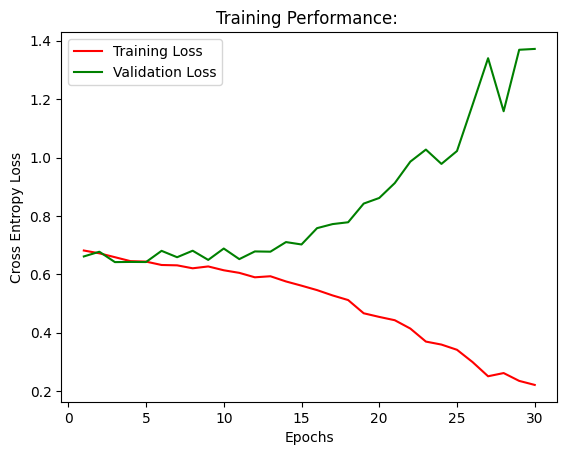

In [19]:
plt.plot(logs["epochs"], logs["training_loss"],  "r-",  label="Training Loss")
plt.plot(logs["epochs"], logs["validation_loss"], "g-", label="Validation Loss")

plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Performance: ")
plt.show()